In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv



我将主要参考[How I made top 0.3% on a Kaggle competition](https://www.kaggle.com/code/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition#How-I-made-top-0.3%-on-a-Kaggle-competition)来编写这次的作业
下面是大致的流程：
* EDA(Exploratory Data Analysis)数据探索，主要是对目标变量进行分析，这里还参考了[Comprehensive data exploration with Python](https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python)
* Feature engineering 特征工程
  这都是预处理
* 最后是模型训练
  

In [2]:
# Essentials
import numpy as np
import pandas as pd
import datetime
import random

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

import os
print(os.listdir("../input/"))

['house-prices-advanced-regression-techniques']


In [3]:
# Read in the dataset as a dataframe
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
train.shape, test.shape

((1460, 81), (1459, 80))

In [4]:
# Remove the Ids from train and test, as they are unique for each row and hence not useful for the model
train_ID = train['Id']
test_ID = test['Id']
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)
train.shape, test.shape

((1460, 80), (1459, 79))

## 预处理

SalePrice的分布。

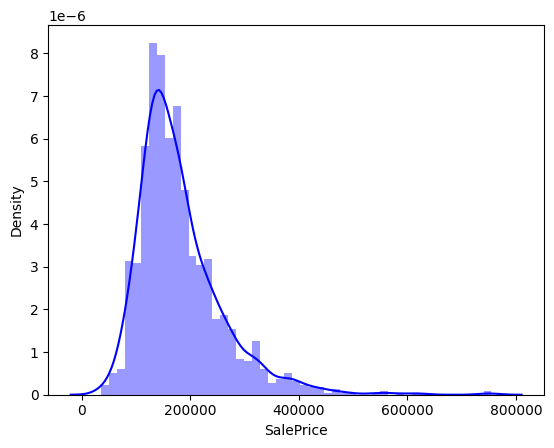

In [5]:
#Check the new distribution 
sns.distplot(train['SalePrice'], color="b");

用log变化转为拟正太

In [6]:
# log(1+x) transform
train["SalePrice"] = np.log1p(train["SalePrice"])


 mu = 12.02 and sigma = 0.40



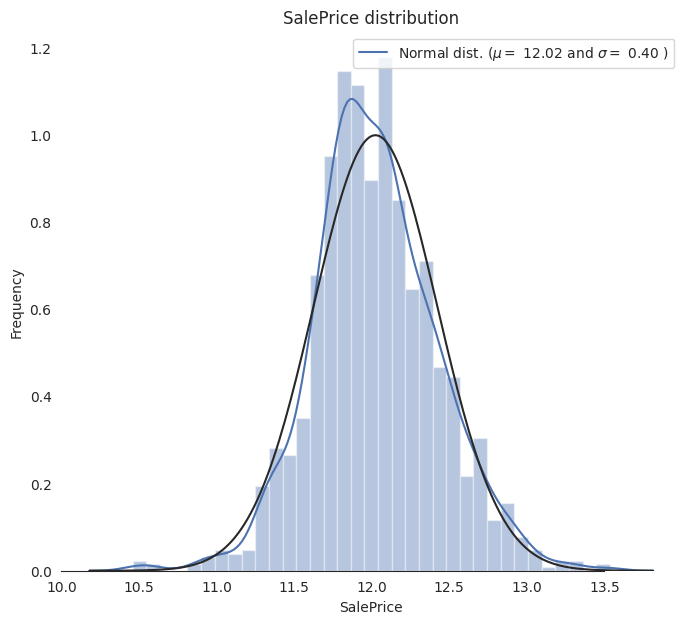

In [7]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm, color="b");

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)

plt.show()

In [8]:
# Split features and labels
train_labels = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape

(2919, 79)

In [9]:
#missing data
total = all_features.isnull().sum().sort_values(ascending=False)
percent = (all_features.isnull().sum()/all_features.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
MasVnrType,1766,0.605002
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageFinish,159,0.054471
GarageCond,159,0.054471
GarageQual,159,0.054471


<Axes: xlabel='Percent'>

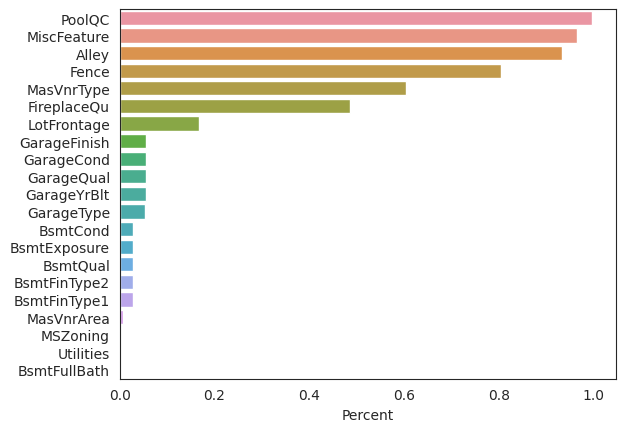

In [10]:
sns.barplot(y=missing_data.index[:21],x=missing_data['Percent'][:21])

In [11]:
# Some of the non-numeric predictors are stored as numbers; convert them into strings 
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)

In [12]:
def handle_missing(features):
    # the data description states that NA refers to typical ('Typ') values
    features['Functional'] = features['Functional'].fillna('Typ')
    # Replace the missing values in each of the columns below with their mode
    features['Electrical'] = features['Electrical'].fillna("SBrkr")
    features['KitchenQual'] = features['KitchenQual'].fillna("TA")
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    # the data description stats that NA refers to "No Pool"
    features["PoolQC"] = features["PoolQC"].fillna("None")
    # Replacing the missing values with 0, since no garage = no cars in garage
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        features[col] = features[col].fillna(0)
    # Replacing the missing values with None
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')
    # NaN values for these categorical basement features, means there's no basement
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        features[col] = features[col].fillna('None')
        
    # Group the by neighborhoods, and fill in missing value by the median LotFrontage of the neighborhood
    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # We have no particular intuition around how to fill in the rest of the categorical features
    # So we replace their missing values with None
    objects = []
    for i in features.columns:
        if features[i].dtype == object:
            objects.append(i)
    features.update(features[objects].fillna('None'))
        
    # And we do the same thing for numerical features, but this time with 0s
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    features.update(features[numeric].fillna(0))    
    return features

all_features = handle_missing(all_features)

In [13]:
percent = (all_features.isnull().sum()/all_features.isnull().count()).sort_values(ascending=False)
percent.head()

SaleCondition    0.0
MSSubClass       0.0
MSZoning         0.0
LotFrontage      0.0
LotArea          0.0
dtype: float64

### Fix skewed features

In [14]:
# Fetch all numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in all_features.columns:
    if all_features[i].dtype in numeric_dtypes:
        numeric.append(i)
len(numeric)

33

[Text(0.5, 1.0, 'Numeric Distribution of Features')]

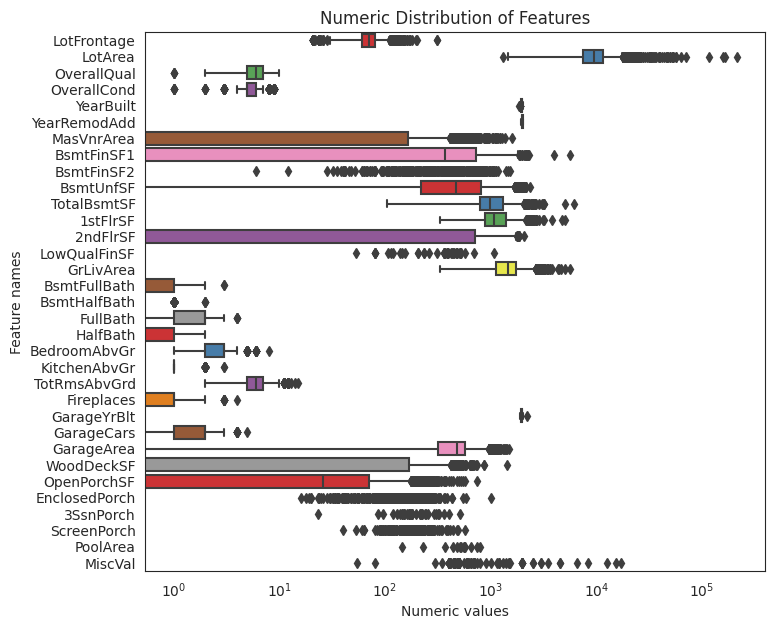

In [15]:
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[numeric] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")

In [16]:
# Find skewed numerical features
skew_features = all_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 25 numerical features with Skew > 0.5 :


MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146143
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931594
dtype: float64

将偏态的数据用boxcox1p，用于进行 Box-Cox 变换，用于 正态化（normalize） 数据。这个我不知道为啥我用的时候会报错嘿嘿
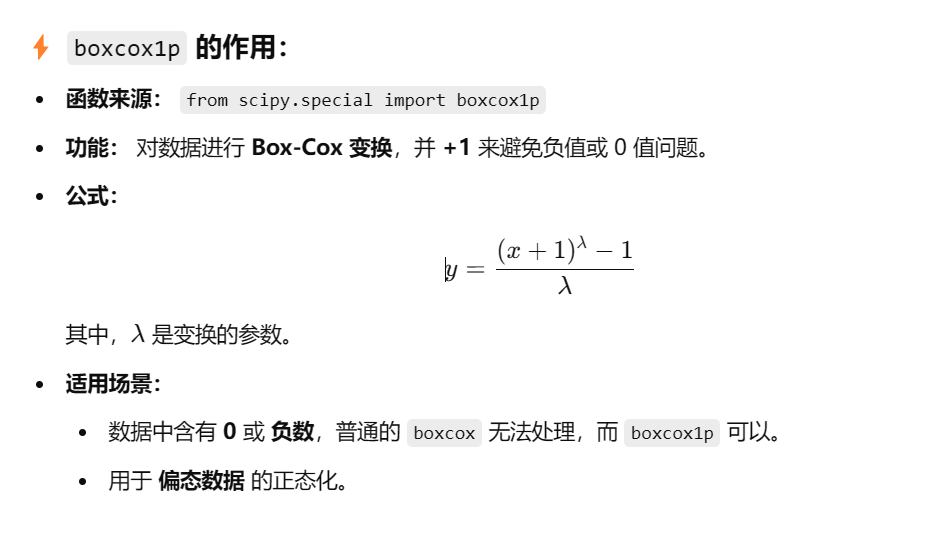

还有其他常见方法

数据中有负值？👉 Yeo-Johnson我用的这个

数据偏态强但为正数？👉 Box-Cox 或 Log

追求完美的正态化？👉 Quantile Transformer



In [17]:
for i in skew_index:
    feature = all_features[i]
    
    # 检查负数、NaN、无穷大
    if (feature <= -1).any():
        print(f"Feature '{i}' has values <= -1, which is invalid for boxcox1p.")
    if feature.isnull().any():
        print(f"Feature '{i}' contains NaN values.")
    if np.isinf(feature).any():
        print(f"Feature '{i}' contains infinite values.")


[Text(0.5, 1.0, 'Numeric Distribution of Features')]

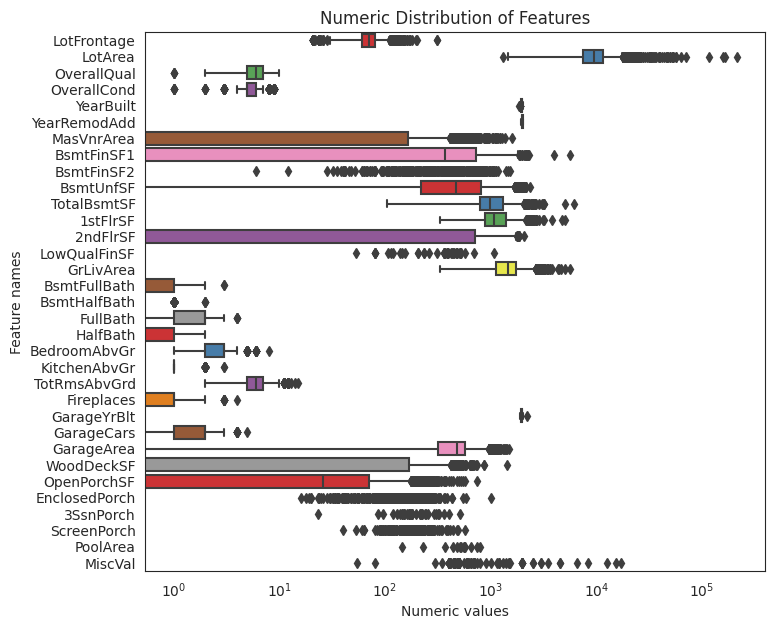

In [18]:
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[numeric] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")

### Encode categorical features

In [19]:
all_features = pd.get_dummies(all_features).reset_index(drop=True)
all_features.shape

(2919, 333)

In [20]:
# Remove any duplicated column names
all_features = all_features.loc[:,~all_features.columns.duplicated()]
all_features.shape

(2919, 333)

### Recreate training and test sets
x是前train_labels，x_test是train_labels之后的

In [21]:
X= all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]
X.shape, train_labels.shape, X_test.shape

((1460, 333), (1460,), (1459, 333))

## Train a model

In [22]:
# Setup cross validation folds
kf = KFold(n_splits=12, random_state=42, shuffle=True)

In [23]:
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

你的 **Stacking** 基础模型包含以下几类：  

1. **Boosting 类模型**（提升树）  
   - [**LightGBM (`lightgbm`)**](https://blog.csdn.net/GFDGFHSDS/article/details/104779767)
   - **XGBoost (`xgboost`)** 🔥  
   - [**梯度提升回归 (`gbr`)**](https://blog.csdn.net/xlsj228/article/details/105122816)

3. **线性模型**  
   - **Ridge 回归 (`ridge`)**  

4. **支持向量机**  
   - **SVR (`svr`)**  

5. **集成学习（Bagging）**  
   - **随机森林 (`rf`)** 🌳  

[**Stacking**](https://blog.csdn.net/weixin_46803857/article/details/128700297) 组合了 **Boosting + 线性模型 + SVM + 随机森林**，最终用 **XGBoost** 作为 `meta_regressor` 进行最终预测。  

想加入 **深度学习模型**，可以用 **PyTorch 或 Keras MLP（多层感知机）**，然后用 `BaseEstimator` 包装成 scikit-learn 兼容的模型。🚀

### 再加个mlp

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, RegressorMixin

In [25]:
# 定义 PyTorch MLP 回归模型
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super(MLPRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),  # 添加 Dropout
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),  # 添加 Dropout
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.model(x)


class SklearnMLP(BaseEstimator, RegressorMixin):
    def __init__(self, input_dim, epochs=100, lr=0.01, batch_size=32):
        self.input_dim = input_dim
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = MLPRegressor(input_dim).to(self.device)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
    
    def fit(self, X, y):
        
        print(X.shape)  # 输出 X 的形状
        

        # 转换为 torch.Tensor
        X = torch.tensor(X.values.astype(float), dtype=torch.float32).to(self.device)
        y = torch.tensor(y.values.astype(float), dtype=torch.float32).view(-1, 1).to(self.device)

        # 使用 DataLoader 进行小批量训练
        dataset = torch.utils.data.TensorDataset(X, y)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            for batch_X, batch_y in dataloader:
                self.optimizer.zero_grad()
                predictions = self.model(batch_X)
                loss = self.criterion(predictions, batch_y)
                loss.backward()
                self.optimizer.step()
    
    def predict(self, X):
        X = torch.tensor(X.values, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            predictions = self.model(X).cpu().numpy()
        return predictions.flatten()
# 创建 MLP 模型
mlp = SklearnMLP(input_dim=X.shape[1], epochs=200, lr=0.001, batch_size=64)

In [26]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ridge, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [27]:
scores = {}

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())


lightgbm: 0.1205 (0.0213)


In [28]:
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())


xgboost: 0.1397 (0.0267)


In [29]:
  
score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())



SVR: 0.1860 (0.0340)


In [30]:
score = cv_rmse(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())



ridge: 0.1368 (0.0413)


In [31]:
score = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())



rf: 0.1434 (0.0274)


In [32]:
score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())

gbr: 0.1195 (0.0261)


In [33]:
score = cv_rmse(mlp)
print("mlp: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['mlp'] = (score.mean(), score.std())

(1338, 333)
(1338, 333)
(1338, 333)
(1338, 333)
(1338, 333)
(1338, 333)
(1338, 333)
(1338, 333)
(1339, 333)
(1339, 333)
(1339, 333)
(1339, 333)
mlp: nan (nan)


In [34]:
scores

{'lgb': (0.12053855768451043, 0.021286080643816395),
 'xgb': (0.1396583304294119, 0.026746890209419293),
 'svr': (0.1859772593852066, 0.03396935981740504),
 'ridge': (0.13684191225700518, 0.04133123810448922),
 'rf': (0.1433767759339371, 0.027410371664763674),
 'gbr': (0.11951598122362905, 0.026144549429238155),
 'mlp': (nan, nan)}

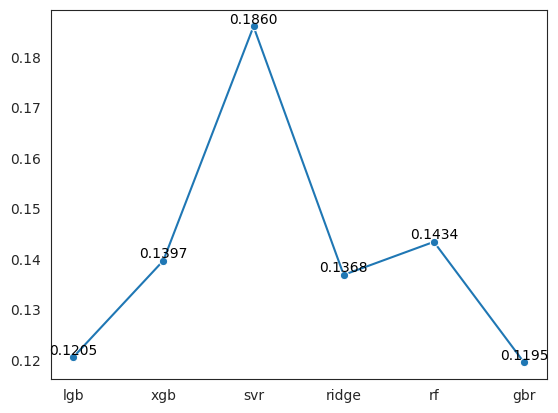

In [35]:
# 解析 scores 数据
models = list(scores.keys())  # 获取模型名称
values = [scores[m][0] for m in models]  # 取均值（第一个值）
sns.lineplot(x=models,y=values,marker="o")
# 在数据点上显示数值
for i, value in enumerate(values):
    plt.text(i, value, f"{value:.4f}", ha="center", va="bottom", fontsize=10, color="black")

In [36]:
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(train_labels))

stack_gen


In [37]:
print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, train_labels)

lightgbm


In [38]:
print('xgboost')
xgb_model_full_data = xgboost.fit(X, train_labels)

xgboost


In [39]:
print('Svr')
svr_model_full_data = svr.fit(X, train_labels)

Svr


In [40]:
print('Ridge')
ridge_model_full_data = ridge.fit(X, train_labels)

Ridge


In [41]:
print('RandomForest')
rf_model_full_data = rf.fit(X, train_labels)

RandomForest


In [42]:
print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, train_labels)

GradientBoosting


In [43]:
# Blend models in order to make the final predictions more robust to overfitting
def blended_predictions(X):
    return ((0.1 * ridge_model_full_data.predict(X)) + \
            (0.2 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.1 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.05 * rf_model_full_data.predict(X)) + \
            (0.35 * stack_gen_model.predict(np.array(X))))

In [44]:
# Get final precitions from the blended model
blended_score = rmsle(train_labels, blended_predictions(X))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.07597502288891632
